![](imgs/kodolamaczlogo.png)

# Przetwarzanie Big Data z użyciem Apache Spark

Autor notebooka: Jakub Nowacki.


## Podstawy Spark SQL - People

In [1]:
import pyspark
import pyspark.sql.functions as func

spark = pyspark.sql.SparkSession.builder \
    .appName('people') \
    .getOrCreate()
    
# W wersji Spark < 2
#sc = pyspark.SparkContext(appName='people')
#spark = pyspark.sql.SQLContext(sc)

In [ ]:
spark.read.

In [2]:
people = spark.read.json('data/people.json')

In [3]:
people.printSchema()

root
 |-- age: long (nullable = true)
 |-- children: long (nullable = true)
 |-- gender: string (nullable = true)
 |-- name: string (nullable = true)
 |-- surname: string (nullable = true)



In [6]:
people.show()

+---+--------+------+-----+-------+
|age|children|gender| name|surname|
+---+--------+------+-----+-------+
| 25|       2|  male| John|    Doe|
| 35|       0|  male| Mike|    Foo|
| 65|       1|female|  Liz|    Bar|
| 34|       3|female|Emily|    Doe|
+---+--------+------+-----+-------+



## Używająć SQL

Do zapytań na DataFrames możemy użyc standardowego SQLa, dla którego będą one traktowane jak tabele w bazie danych. Pamiętaj, że Spark wspiera składnię ANSI/ISO SQL, więc konstrukcje typowe dla poszczególnych baz danych mogę nie być dostępne.

In [11]:
# Musisz najpierw zarejestrować tabelę zanim ją użyjesz w zapytaniu.
# Pamiętaj, że alias może mieć dowolną nazwę; nie jest on zależny od nazwy zmiennej.
people.createOrReplaceTempView('people')

In [12]:
# Teraz możemy wykonywać zapytania
r = spark.sql('SELECT * FROM people')
# Wynikiem jest nowy DataFrame
print(type(r))
# Metoda show() drukuje przykład danych
r.show()

<class 'pyspark.sql.dataframe.DataFrame'>
+---+--------+------+-----+-------+
|age|children|gender| name|surname|
+---+--------+------+-----+-------+
| 25|       2|  male| John|    Doe|
| 35|       0|  male| Mike|    Foo|
| 65|       1|female|  Liz|    Bar|
| 34|       3|female|Emily|    Doe|
+---+--------+------+-----+-------+



In [9]:
spark.catalog.listTables()

[Table(name='people', database=None, description=None, tableType='TEMPORARY', isTemporary=True)]

In [14]:
spark.sql('SELECT name, age FROM people').show()

+-----+---+
| name|age|
+-----+---+
| John| 25|
| Mike| 35|
|  Liz| 65|
|Emily| 34|
+-----+---+



In [15]:
spark.sql('SELECT * FROM people WHERE age > 30').show()

+---+--------+------+-----+-------+
|age|children|gender| name|surname|
+---+--------+------+-----+-------+
| 35|       0|  male| Mike|    Foo|
| 65|       1|female|  Liz|    Bar|
| 34|       3|female|Emily|    Doe|
+---+--------+------+-----+-------+



In [16]:
# Możesz użyć docstring do dłuższych zapytań
query = """
    SELECT 
        gender,
        count(*) AS count, 
        avg(age) AS avg_age, 
        avg(children) AS avg_children 
    FROM people 
    GROUP BY gender
"""
spark.sql(query).show()

+------+-----+-------+------------+
|gender|count|avg_age|avg_children|
+------+-----+-------+------------+
|female|    2|   49.5|         2.0|
|  male|    2|   30.0|         1.0|
+------+-----+-------+------------+



In [17]:
# Czasami trzeba uważać, np. poniższe nie zadziała
#spark.sql("SELECT name, surname, max(age) as maxAge FROM people WHERE gender = 'male'").show()
# Ale to zadziała poprawnie
spark.sql("SELECT first(name) AS name, first(surname) AS surname, max(age) as maxAge FROM people WHERE gender = 'male'").show()

+----+-------+------+
|name|surname|maxAge|
+----+-------+------+
|John|    Doe|    35|
+----+-------+------+



## Używanie metod DataFrame

Alternatywnie do zapytań SQL, Spark DataFrame posiadają metody podobne do SQL do budowania zapytań. Zaletą w stosunku do SQL jest m.in. to, że większość błędów w zapytaniach wykrywana jest w czasie kompilacji. 

In [18]:
people.select('name').show()

+-----+
| name|
+-----+
| John|
| Mike|
|  Liz|
|Emily|
+-----+



In [21]:
people.where(people.age > 30).show()

+---+--------+------+-----+-------+
|age|children|gender| name|surname|
+---+--------+------+-----+-------+
| 35|       0|  male| Mike|    Foo|
| 65|       1|female|  Liz|    Bar|
| 34|       3|female|Emily|    Doe|
+---+--------+------+-----+-------+



In [24]:
people.groupBy('gender') \
    .agg(func.avg('age').alias('avg_age'), 
         func.max('children').alias('max_children'))\
    .show()

+------+-------+------------+
|gender|avg_age|max_children|
+------+-------+------------+
|female|   49.5|           3|
|  male|   30.0|           2|
+------+-------+------------+



In [23]:
people.groupBy('gender').pivot('name').agg(func.avg('age')).show()

+------+-----+----+----+----+
|gender|Emily|John| Liz|Mike|
+------+-----+----+----+----+
|female| 34.0|null|65.0|null|
|  male| null|25.0|null|35.0|
+------+-----+----+----+----+



In [26]:
people.where(people.gender == 'male') \
    .select(
        func.first('name').alias('name'), 
        func.first('surname').alias('surname'), 
        func.max('age').alias('maxAge')) \
    .show()

+----+-------+------+
|name|surname|maxAge|
+----+-------+------+
|John|    Doe|    35|
+----+-------+------+



,avg_age,max_children
gender,,
female,49.5,3
male,30.0,2


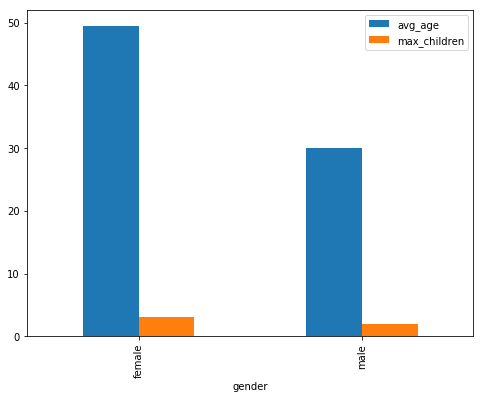

In [28]:
import matplotlib
%matplotlib inline

# Można otrzymywać data frame Pandas bezpośrednio z DataFrames; pamiętaj jednak o rozmiarze danych...
p = people.groupBy('gender').agg(func.avg('age').alias('avg_age'), 
                                 func.max('children').alias('max_children')) \
        .toPandas().set_index('gender')
p.plot(kind='bar', figsize=(8,6))
p

## Zadania

Wypróbuj dostępne metody SQL i DataFrames. Sugestie:

* zbadaj dostępne funkcje
* spróbuj zapisać DataFrame
* spróbuj przekształcić DataFrame do RDD (podpowiedź: RDD zawiera obiekty Row)

In [29]:
people.rdd.

[Row(age=25, children=2, gender='male', name='John', surname='Doe'),
 Row(age=35, children=0, gender='male', name='Mike', surname='Foo'),
 Row(age=65, children=1, gender='female', name='Liz', surname='Bar'),
 Row(age=34, children=3, gender='female', name='Emily', surname='Doe')]

In [31]:
p = people.collect()
p

[Row(age=25, children=2, gender='male', name='John', surname='Doe'),
 Row(age=35, children=0, gender='male', name='Mike', surname='Foo'),
 Row(age=65, children=1, gender='female', name='Liz', surname='Bar'),
 Row(age=34, children=3, gender='female', name='Emily', surname='Doe')]

In [33]:
r = p[0]
r

Row(age=25, children=2, gender='male', name='John', surname='Doe')

In [35]:
r['age']

25

In [36]:
r.age

25

In [37]:
r[0]

25

In [39]:
r.asDict()

{'age': 25, 'children': 2, 'gender': 'male', 'name': 'John', 'surname': 'Doe'}

In [41]:
[v for v in r]

[25, 2, 'male', 'John', 'Doe']

In [42]:
df = people.toPandas()
df

,age,children,gender,name,surname
0,25,2,male,John,Doe
1,35,0,male,Mike,Foo
2,65,1,female,Liz,Bar
3,34,3,female,Emily,Doe


In [43]:
df.to_excel('blah.xlsx')